All imports successful!
SIMPLIFIED DEEPFM DEMONSTRATION

1. Generating data...
Dataset shape: (3000, 10)
Target distribution: {0: 2100, 1: 900}
Positive rate: 0.300

2. Splitting data...
Train: 2100 samples
Val: 450 samples
Test: 450 samples

3. Features:
  Categorical: ['user_id', 'item_id', 'gender', 'city', 'category']
  Numerical: ['age', 'price', 'rating', 'purchase_count']

4. Creating datasets...

Sample data shapes:
  Categorical: torch.Size([5]), values: [232, 38, 0, 0, 0]
  Numerical: torch.Size([4]), values: [1.335015892982483, -1.4555288553237915, 1.5382174253463745]
  Target: 0.0

5. Feature sizes:
  Sparse feature sizes: [300, 100, 2, 5, 4]
  Number of sparse features: 5
  Dense feature dimension: 4

Checking index ranges:
  user_id: max index = 299, embedding size = 300
  item_id: max index = 99, embedding size = 100
  gender: max index = 1, embedding size = 2
  city: max index = 4, embedding size = 5
  category: max index = 3, embedding size = 4

6. Creating dataloaders

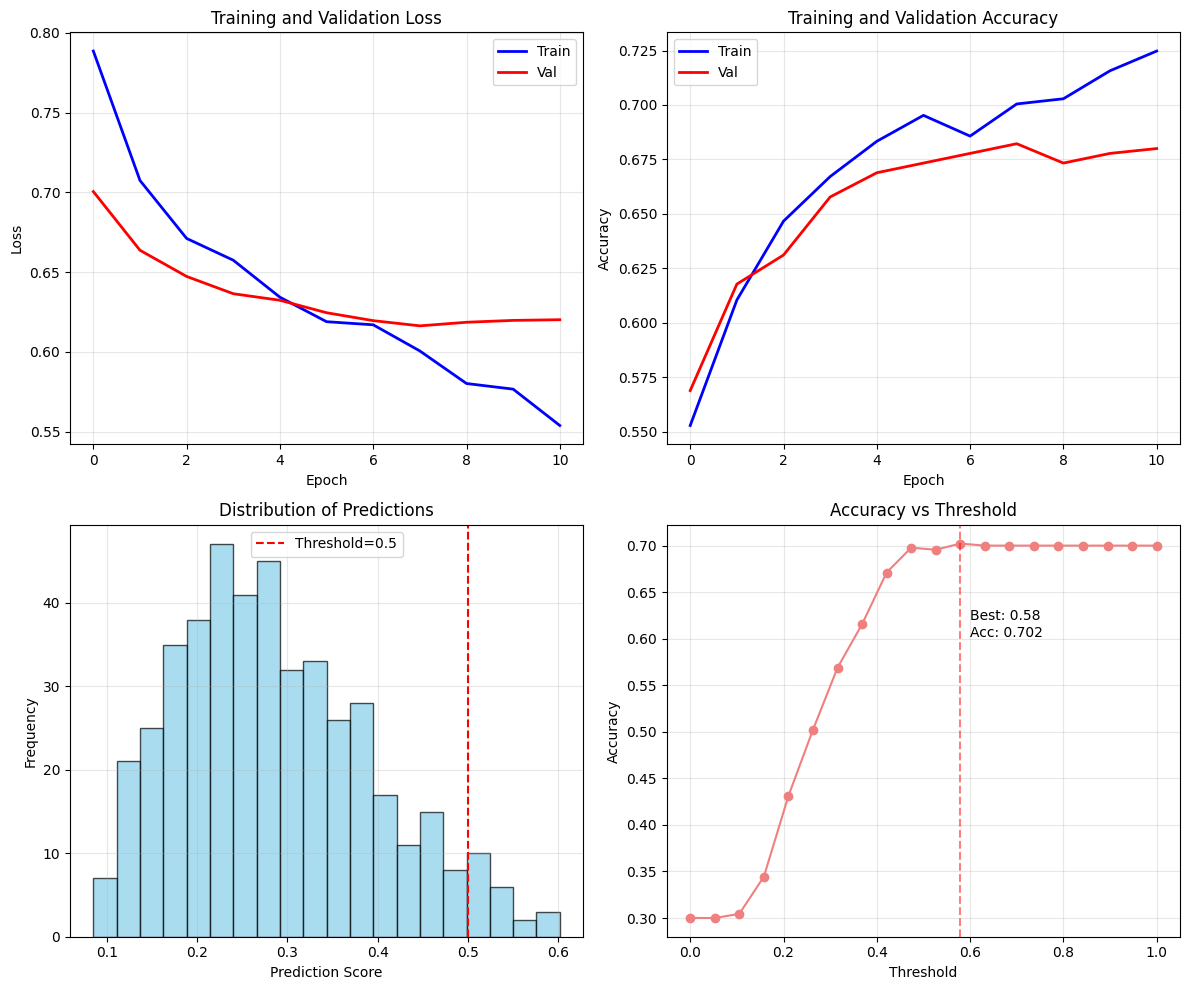


12. Sample predictions:
--------------------------------------------------------------------------------

Sample 407: User 56, Item 96
  Prediction: 0.5683 -> Click
  Actual: 0 -> No Click
  Correct: ✗

Sample 444: User 205, Item 67
  Prediction: 0.0901 -> No Click
  Actual: 0 -> No Click
  Correct: ✓

Sample 117: User 50, Item 19
  Prediction: 0.3703 -> No Click
  Actual: 1 -> Click
  Correct: ✗

Sample 30: User 42, Item 3
  Prediction: 0.3428 -> No Click
  Actual: 0 -> No Click
  Correct: ✓

Sample 415: User 44, Item 49
  Prediction: 0.4818 -> No Click
  Actual: 1 -> Click
  Correct: ✗

13. Feature importance analysis...


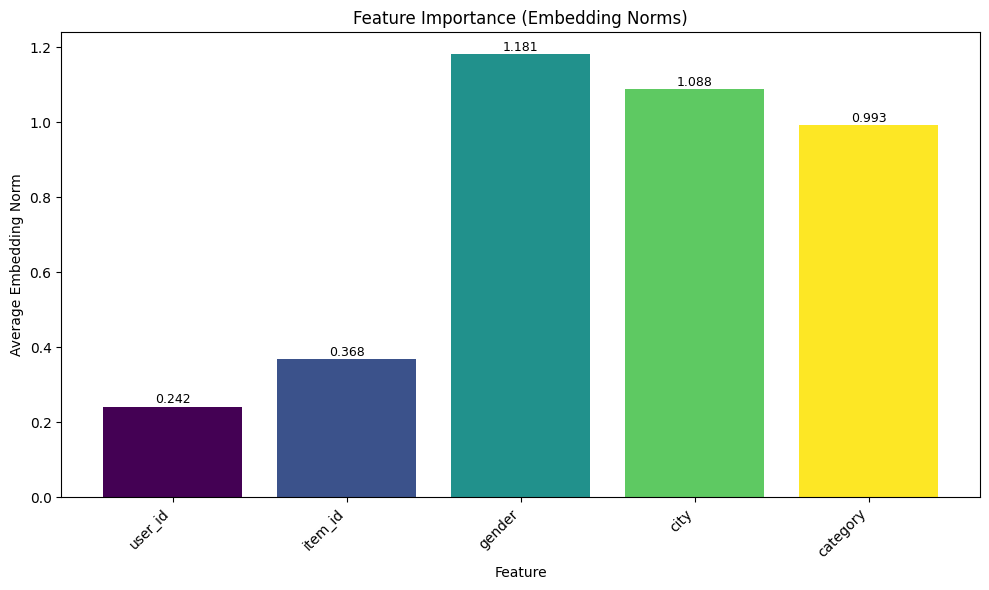


Top features by importance:
  1. gender: 1.1810
  2. city: 1.0884
  3. category: 0.9927

DEEPFM DEMONSTRATION COMPLETE!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")

# ============================================
# 1. ГЕНЕРАЦИЯ СИНТЕТИЧЕСКИХ ДАННЫХ
# ============================================

def generate_deepfm_data(n_samples=5000, n_users=500, n_items=200):
    """
    Генерация данных для DeepFM
    """
    np.random.seed(42)

    # Базовые данные
    data = {
        'user_id': np.random.randint(1, n_users + 1, n_samples),
        'item_id': np.random.randint(1, n_items + 1, n_samples),
        'age': np.random.randint(18, 65, n_samples),
        'gender': np.random.choice(['M', 'F'], n_samples, p=[0.55, 0.45]),
        'city': np.random.choice(['NY', 'LA', 'SF', 'CH', 'MI'], n_samples),
        'category': np.random.choice(['electronics', 'books', 'clothing', 'home'], n_samples),
        'price': np.random.uniform(5, 500, n_samples),
        'rating': np.random.uniform(1, 5, n_samples),
        'purchase_count': np.random.randint(1, 50, n_samples),
    }

    df = pd.DataFrame(data)

    # Целевая переменная (бинарная: клик/покупка)
    prob = 0.3 + 0.001 * df['rating'] + 0.0005 * df['purchase_count']
    prob = np.clip(prob, 0, 1)
    df['target'] = (np.random.random(n_samples) < prob).astype(int)

    return df

# ============================================
# 2. ПОДГОТОВКА ДАННЫХ ДЛЯ DeepFM
# ============================================

class DeepFMDataset(Dataset):
    """Dataset для DeepFM модели"""

    def __init__(self, df: pd.DataFrame, categorical_cols: List[str],
                 numerical_cols: List[str], target_col: str = 'target'):
        self.df = df
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.target_col = target_col

        # Label Encoding для категориальных признаков
        self.label_encoders = {}
        self.encoded_data = df.copy()

        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                self.encoded_data[col] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le

        # Standard Scaling для числовых признаков
        self.scaler = StandardScaler()
        if numerical_cols:
            numerical_data = df[numerical_cols].values
            scaled_numerical = self.scaler.fit_transform(numerical_data)
            for i, col in enumerate(numerical_cols):
                self.encoded_data[col] = scaled_numerical[:, i]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Категориальные признаки (sparse)
        categorical_features = []
        for col in self.categorical_cols:
            if col in self.encoded_data.columns:
                # Используем индексы как есть (начинаются с 0)
                feature_value = int(self.encoded_data.iloc[idx][col])
                categorical_features.append(feature_value)

        # Числовые признаки (dense)
        numerical_features = []
        for col in self.numerical_cols:
            if col in self.encoded_data.columns:
                numerical_features.append(float(self.encoded_data.iloc[idx][col]))

        # Целевая переменная
        target = float(self.df.iloc[idx][self.target_col]) if self.target_col in self.df.columns else 0.0

        return {
            'categorical': torch.LongTensor(categorical_features),
            'numerical': torch.FloatTensor(numerical_features),
            'target': torch.FloatTensor([target])
        }

    def get_feature_sizes(self):
        """Возвращает размеры категориальных признаков (для embedding слоев)"""
        feature_sizes = []
        for col in self.categorical_cols:
            if col in self.label_encoders:
                # Размер embedding = количество уникальных значений
                feature_sizes.append(len(self.label_encoders[col].classes_))
        return feature_sizes

    def get_numerical_dim(self):
        """Возвращает размерность числовых признаков"""
        return len(self.numerical_cols)

# ============================================
# 3. УПРОЩЕННАЯ РЕАЛИЗАЦИЯ DEEPFM МОДЕЛИ
# ============================================

class SimpleFactorizationMachine(nn.Module):
    """Упрощенная Factorization Machine часть"""

    def __init__(self, sparse_feature_sizes, embedding_dim=10):
        super().__init__()
        self.sparse_feature_sizes = sparse_feature_sizes
        self.num_fields = len(sparse_feature_sizes)
        self.embedding_dim = embedding_dim

        # Embedding слои для каждого sparse признака
        self.embeddings = nn.ModuleList([
            nn.Embedding(size, embedding_dim)
            for size in sparse_feature_sizes
        ])

        # Линейные слои для каждого sparse признака
        self.linear = nn.ModuleList([
            nn.Embedding(size, 1)
            for size in sparse_feature_sizes
        ])

        # Bias
        self.bias = nn.Parameter(torch.zeros(1))

        # Инициализация
        for emb in self.embeddings:
            nn.init.xavier_uniform_(emb.weight)
        for lin in self.linear:
            nn.init.xavier_uniform_(lin.weight)

    def forward(self, x_sparse):
        """
        Args:
            x_sparse: [batch_size, num_fields]
        """
        batch_size = x_sparse.size(0)

        # 1. Linear часть (first-order interactions)
        linear_output = self.bias
        for i in range(self.num_fields):
            linear_output = linear_output + self.linear[i](x_sparse[:, i]).squeeze()

        # 2. FM часть (second-order interactions)
        # Получаем embedding для всех признаков
        embeddings = []
        for i in range(self.num_fields):
            emb = self.embeddings[i](x_sparse[:, i])  # [batch_size, embedding_dim]
            embeddings.append(emb)

        # Вычисляем FM взаимодействия
        sum_of_squares = torch.zeros(batch_size, self.embedding_dim).to(x_sparse.device)
        square_of_sums = torch.zeros(batch_size, self.embedding_dim).to(x_sparse.device)

        for i in range(self.num_fields):
            square_of_sums = square_of_sums + embeddings[i]
            sum_of_squares = sum_of_squares + embeddings[i] ** 2

        fm_output = 0.5 * torch.sum(square_of_sums ** 2 - sum_of_squares, dim=1)

        return linear_output + fm_output


class DeepFM(nn.Module):
    """Упрощенная DeepFM модель"""

    def __init__(self, sparse_feature_sizes, dense_feature_dim,
                 embedding_dim=10, deep_hidden_dims=[64, 32], dropout=0.2):
        super().__init__()

        self.sparse_feature_sizes = sparse_feature_sizes
        self.dense_feature_dim = dense_feature_dim
        self.embedding_dim = embedding_dim
        self.num_fields = len(sparse_feature_sizes)

        # 1. FM часть
        self.fm = SimpleFactorizationMachine(sparse_feature_sizes, embedding_dim)

        # 2. Deep часть
        # Входной размер: sparse embeddings + dense features
        deep_input_dim = self.num_fields * embedding_dim + dense_feature_dim

        deep_layers = []
        prev_dim = deep_input_dim

        for hidden_dim in deep_hidden_dims:
            deep_layers.append(nn.Linear(prev_dim, hidden_dim))
            deep_layers.append(nn.BatchNorm1d(hidden_dim))
            deep_layers.append(nn.ReLU())
            deep_layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        # Выходной слой deep части
        deep_layers.append(nn.Linear(prev_dim, 1))

        self.deep_net = nn.Sequential(*deep_layers)

        # 3. Инициализация весов deep части
        for layer in self.deep_net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

        # 4. Выходной слой (sigmoid для бинарной классификации)
        self.sigmoid = nn.Sigmoid()

        # 5. BatchNorm для dense признаков
        if dense_feature_dim > 0:
            self.dense_bn = nn.BatchNorm1d(dense_feature_dim)
        else:
            self.dense_bn = None

    def forward(self, x_sparse, x_dense=None):
        batch_size = x_sparse.size(0)

        # 1. FM часть
        fm_output = self.fm(x_sparse)

        # 2. Deep часть
        # Получаем embedding для sparse признаков
        sparse_embeddings = []
        for i in range(self.num_fields):
            emb = self.fm.embeddings[i](x_sparse[:, i])
            sparse_embeddings.append(emb)

        # Конкатенируем все embedding
        sparse_embedding_concat = torch.cat(sparse_embeddings, dim=1)

        # Обрабатываем dense признаки
        if x_dense is not None and x_dense.size(1) > 0:
            if self.dense_bn is not None:
                x_dense = self.dense_bn(x_dense)
            deep_input = torch.cat([sparse_embedding_concat, x_dense], dim=1)
        else:
            deep_input = sparse_embedding_concat

        # Пропускаем через deep сеть
        deep_output = self.deep_net(deep_input).squeeze()

        # 3. Комбинируем FM и Deep части
        combined = fm_output + deep_output

        # 4. Sigmoid активация
        output = self.sigmoid(combined)

        return output

# ============================================
# 4. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛИ
# ============================================

class DeepFMTrainer:
    """Класс для обучения DeepFM"""

    def __init__(self, model, device='cpu', learning_rate=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def train_epoch(self, dataloader):
        """Обучение на одной эпохе"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, batch in enumerate(dataloader):
            # Перемещаем данные на устройство
            categorical = batch['categorical'].to(self.device)
            numerical = batch['numerical'].to(self.device)
            targets = batch['target'].to(self.device)

            # Forward pass
            outputs = self.model(categorical, numerical)
            loss = self.criterion(outputs, targets.squeeze())

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # Статистика
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == targets.squeeze()).sum().item()
            total += targets.size(0)

        accuracy = correct / total if total > 0 else 0
        avg_loss = total_loss / len(dataloader)

        return avg_loss, accuracy

    def evaluate(self, dataloader):
        """Оценка модели"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in dataloader:
                categorical = batch['categorical'].to(self.device)
                numerical = batch['numerical'].to(self.device)
                targets = batch['target'].to(self.device)

                outputs = self.model(categorical, numerical)
                loss = self.criterion(outputs, targets.squeeze())

                total_loss += loss.item()
                predictions = (outputs > 0.5).float()
                correct += (predictions == targets.squeeze()).sum().item()
                total += targets.size(0)

        accuracy = correct / total if total > 0 else 0
        avg_loss = total_loss / len(dataloader)

        return avg_loss, accuracy

    def train(self, train_loader, val_loader, epochs=20, early_stopping_patience=5):
        """Полный цикл обучения"""

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        best_val_loss = float('inf')
        patience = 0

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Обучение
            train_loss, train_acc = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Валидация
            val_loss, val_acc = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
                # Сохраняем лучшую модель
                torch.save(self.model.state_dict(), 'best_deepfm_model.pth')
            else:
                patience += 1

            if patience >= early_stopping_patience:
                print(f"\nEarly stopping after {epoch+1} epochs")
                break

        # Загружаем лучшую модель
        self.model.load_state_dict(torch.load('best_deepfm_model.pth'))

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accs,
            'val_accuracies': val_accs
        }

# ============================================
# 5. ДЕМОНСТРАЦИЯ РАБОТЫ
# ============================================

def main():
    print("=" * 80)
    print("SIMPLIFIED DEEPFM DEMONSTRATION")
    print("=" * 80)

    # 1. Генерация данных
    print("\n1. Generating data...")
    df = generate_deepfm_data(n_samples=3000, n_users=300, n_items=100)

    print(f"Dataset shape: {df.shape}")
    print(f"Target distribution: {df['target'].value_counts().to_dict()}")
    print(f"Positive rate: {df['target'].mean():.3f}")

    # 2. Разделение данных
    print("\n2. Splitting data...")
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['target'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['target'])

    print(f"Train: {len(train_df)} samples")
    print(f"Val: {len(val_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # 3. Определение признаков
    categorical_cols = ['user_id', 'item_id', 'gender', 'city', 'category']
    numerical_cols = ['age', 'price', 'rating', 'purchase_count']

    print(f"\n3. Features:")
    print(f"  Categorical: {categorical_cols}")
    print(f"  Numerical: {numerical_cols}")

    # 4. Создание datasets
    print("\n4. Creating datasets...")
    train_dataset = DeepFMDataset(train_df, categorical_cols, numerical_cols, 'target')
    val_dataset = DeepFMDataset(val_df, categorical_cols, numerical_cols, 'target')
    test_dataset = DeepFMDataset(test_df, categorical_cols, numerical_cols, 'target')

    # Проверка одного батча
    sample = train_dataset[0]
    print(f"\nSample data shapes:")
    print(f"  Categorical: {sample['categorical'].shape}, values: {sample['categorical'].tolist()}")
    print(f"  Numerical: {sample['numerical'].shape}, values: {sample['numerical'].tolist()[:3]}")
    print(f"  Target: {sample['target'].item()}")

    # 5. Получение размеров признаков
    sparse_feature_sizes = train_dataset.get_feature_sizes()
    dense_feature_dim = train_dataset.get_numerical_dim()

    print(f"\n5. Feature sizes:")
    print(f"  Sparse feature sizes: {sparse_feature_sizes}")
    print(f"  Number of sparse features: {len(sparse_feature_sizes)}")
    print(f"  Dense feature dimension: {dense_feature_dim}")

    # Проверяем, что индексы в пределах
    print(f"\nChecking index ranges:")
    for i, col in enumerate(categorical_cols):
        max_idx = train_dataset.encoded_data[col].max()
        print(f"  {col}: max index = {max_idx}, embedding size = {sparse_feature_sizes[i]}")

    # 6. Создание dataloaders
    print("\n6. Creating dataloaders...")
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 7. Создание модели
    print("\n7. Creating DeepFM model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"  Using device: {device}")

    model = DeepFM(
        sparse_feature_sizes=sparse_feature_sizes,
        dense_feature_dim=dense_feature_dim,
        embedding_dim=8,
        deep_hidden_dims=[32, 16],
        dropout=0.2
    )

    print(f"\n  Model summary:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")

    # 8. Проверка forward pass
    print("\n8. Testing forward pass...")
    try:
        test_batch = next(iter(train_loader))
        with torch.no_grad():
            test_output = model(
                test_batch['categorical'].to(device),
                test_batch['numerical'].to(device)
            )
        print(f"  Forward pass successful!")
        print(f"  Output shape: {test_output.shape}")
        print(f"  Output range: [{test_output.min().item():.4f}, {test_output.max().item():.4f}]")
    except Exception as e:
        print(f"  Error in forward pass: {e}")
        return

    # 9. Обучение модели
    print("\n9. Training model...")
    trainer = DeepFMTrainer(model, device=device, learning_rate=0.001)
    history = trainer.train(train_loader, val_loader, epochs=15, early_stopping_patience=3)

    # 10. Оценка на тестовых данных
    print("\n10. Evaluating on test data...")
    test_loss, test_accuracy = trainer.evaluate(test_loader)
    baseline_accuracy = 1 - test_df['target'].mean()

    print(f"\nTest Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  Baseline (predict majority class): {baseline_accuracy:.4f}")
    print(f"  Improvement: {test_accuracy - baseline_accuracy:.4f}")

    # 11. Визуализация результатов
    print("\n11. Visualizing results...")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss curves
    axes[0, 0].plot(history['train_losses'], label='Train', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_losses'], label='Val', color='red', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot(history['train_accuracies'], label='Train', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_accuracies'], label='Val', color='red', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Предсказания на тестовых данных
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            categorical = batch['categorical'].to(device)
            numerical = batch['numerical'].to(device)
            targets = batch['target'].to(device)

            outputs = model(categorical, numerical)
            test_predictions.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_targets = np.array(test_targets)

    # Distribution of predictions
    axes[1, 0].hist(test_predictions, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_title('Distribution of Predictions')
    axes[1, 0].set_xlabel('Prediction Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(x=0.5, color='red', linestyle='--', label='Threshold=0.5')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy vs Threshold
    thresholds = np.linspace(0, 1, 20)
    accuracies = []

    for threshold in thresholds:
        pred_binary = (test_predictions > threshold).astype(int)
        accuracy = np.mean(pred_binary == test_targets.flatten())
        accuracies.append(accuracy)

    axes[1, 1].plot(thresholds, accuracies, marker='o', color='lightcoral')
    axes[1, 1].set_title('Accuracy vs Threshold')
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    # Optimal threshold
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]

    axes[1, 1].axvline(x=best_threshold, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].text(best_threshold + 0.02, best_accuracy - 0.1,
                   f'Best: {best_threshold:.2f}\nAcc: {best_accuracy:.3f}')

    plt.tight_layout()
    plt.show()

    # 12. Примеры предсказаний
    print("\n12. Sample predictions:")
    print("-" * 80)

    # Берем несколько случайных примеров
    np.random.seed(42)
    sample_indices = np.random.choice(len(test_df), 5, replace=False)

    for idx in sample_indices:
        sample = test_dataset[idx]

        categorical = sample['categorical'].unsqueeze(0).to(device)
        numerical = sample['numerical'].unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(categorical, numerical)

        actual = sample['target'].item()
        predicted = prediction.item()

        # Расшифровка некоторых признаков
        user_id = sample['categorical'][0].item()
        item_id = sample['categorical'][1].item()

        print(f"\nSample {idx}: User {user_id}, Item {item_id}")
        print(f"  Prediction: {predicted:.4f} -> {'Click' if predicted > 0.5 else 'No Click'}")
        print(f"  Actual: {actual:.0f} -> {'Click' if actual > 0.5 else 'No Click'}")
        print(f"  Correct: {'✓' if (predicted > 0.5) == (actual > 0.5) else '✗'}")

    # 13. Анализ важности признаков
    print("\n13. Feature importance analysis...")

    # Получаем нормы embedding векторов
    feature_importances = []
    for i, embedding in enumerate(model.fm.embeddings):
        norms = torch.norm(embedding.weight, dim=1)
        avg_norm = norms.mean().item()
        feature_importances.append(avg_norm)

    # Визуализация
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(categorical_cols)))
    bars = plt.bar(range(len(feature_importances)), feature_importances, color=colors)

    plt.title('Feature Importance (Embedding Norms)')
    plt.xlabel('Feature')
    plt.ylabel('Average Embedding Norm')
    plt.xticks(range(len(categorical_cols)), categorical_cols, rotation=45, ha='right')

    # Добавляем значения
    for bar, importance in zip(bars, feature_importances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{importance:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"\nTop features by importance:")
    sorted_indices = np.argsort(feature_importances)[::-1]
    for i, idx in enumerate(sorted_indices[:3], 1):
        print(f"  {i}. {categorical_cols[idx]}: {feature_importances[idx]:.4f}")

    print(f"\n{'='*80}")
    print("DEEPFM DEMONSTRATION COMPLETE!")
    print("=" * 80)

# Запуск демонстрации
if __name__ == "__main__":
    main()